# Topic modeling

The [topicmod module](api.rst#module-tmtoolkit.topicmod) offers a wide range of tools to facilitate [topic modeling](https://cacm.acm.org/magazines/2012/4/147361-probabilistic-topic-models/fulltext) with Python. This chapter will introduce the following techniques: 

- [parallel topic model computation for different copora and/or parameter sets](#Computing-topic-models-in-parallel)
- [evaluation of topic models (including finding a good set of hyperparameters for the given dataset)](#Evaluation-of-topic-models)
- [common statistics and tools for topic models](#Common-statistics-and-tools-for-topic-models)
- [export of topic models and summaries to different file formats](#Displaying-and-exporting-topic-modeling-results)
- [visualization of topic models](#Visualizing-topic-models)

A quick note on terminology: So far, we spoke about *tokens* or sometimes *terms* when we meant the individual elements that our documents consist of after we applied text preprocessing such as *tokenization* to the raw input text strings. These tokens can be lexicographically correct words, but they don't have to, e.g. when you applied stemming you might have tokens like "argu" in your vocabulary. There may also be numbers or punctuation symbols in your vocabulary. For those topic modeling techniques that tmtoolkit supports, the results are always two probability distributions: a *document-topic distribution* and a *topic-word distribution*. Since the latter is called topic-*word* and not topic-*token* or *-term* distribution, we will also use the term *word* when we mean any token from the corpus' vocabulary.


## An example document-term matrix

tmtoolkit supports topic models that are computed from document-term matrices (DTMs). Just as in the previous chapter, we will at first generate a DTM. However, this time the sample will be bigger:

In [1]:
import random
random.seed(20191120)   # to make the sampling reproducible

import numpy as np
np.set_printoptions(precision=5)

from tmtoolkit.utils import enable_logging
enable_logging()

from tmtoolkit.corpus import Corpus, print_summary


corp = Corpus.from_builtin_corpus('en-NewsArticles', sample=100)
print_summary(corp)

2023-05-03 15:23:11,614:INFO:tmtoolkit:creating Corpus instance with no documents
2023-05-03 15:23:11,615:INFO:tmtoolkit:using serial processing
2023-05-03 15:23:11,832:INFO:tmtoolkit:sampling 100 documents(s) out of 3824
2023-05-03 15:23:11,835:INFO:tmtoolkit:adding text from 100 documents(s)
2023-05-03 15:23:11,836:INFO:tmtoolkit:running NLP pipeline on 100 documents
2023-05-03 15:23:15,164:INFO:tmtoolkit:generating document texts


Corpus with 100 documents in English
> NewsArticles-1137 (226 tokens): These Cool New ' Vertical Forest ' Skyscrapers Are...
> NewsArticles-1141 (914 tokens): Aslef members reject Southern rail deal    Aslef m...
> NewsArticles-1090 (1291 tokens): Martin challenges Fitzgerald over Tusla informatio...
> NewsArticles-1032 (653 tokens): Germany 's right - wing AfD seeks to expel state l...
> NewsArticles-1048 (476 tokens): Espirito Santo police return to work after murder ...
> NewsArticles-113 (1071 tokens): Use talk not tech to tame your children 's online ...
> NewsArticles-104 (31 tokens): Your pictures : Broken resolutions    Each week , ...
> NewsArticles-1126 (163 tokens): This Makeup Palette Has A Game - Changing Little S...
> NewsArticles-1043 (270 tokens): Burhan Ozbilici wins 2017 World Press Photo compet...
> NewsArticles-1036 (835 tokens): Amnesty accuses Tunisian authorities of torture ah...
(and 90 more documents)
total number of tokens: 66637 / vocabulary size: 9469


We will also now generate two DTMs, because we later want to show how you can compute topic models for two different DTMs in parallel. At first, we to some general preprocessing.

In [2]:
from tmtoolkit.corpus import lemmatize, to_lowercase, remove_punctuation

lemmatize(corp)
to_lowercase(corp)
remove_punctuation(corp)

print_summary(corp)

2023-05-03 15:23:15,188:INFO:tmtoolkit:replacing 2186 token hashes
2023-05-03 15:23:15,205:INFO:tmtoolkit:replacing 502 token hashes
2023-05-03 15:23:15,211:INFO:tmtoolkit:generating document texts


Corpus with 100 documents in English
> NewsArticles-1137 (226 tokens): these cool new  vertical forest  skyscraper be des...
> NewsArticles-1141 (914 tokens): aslef member reject southern rail deal  aslef memb...
> NewsArticles-1090 (1291 tokens): martin challenge fitzgerald over tusla information...
> NewsArticles-1032 (653 tokens): germany s right  wing afd seek to expel state lead...
> NewsArticles-1048 (476 tokens): espirito santo police return to work after murder ...
> NewsArticles-113 (1071 tokens): use talk not tech to tame your child s online habi...
> NewsArticles-104 (31 tokens): your picture  break resolution  each week  we publ...
> NewsArticles-1126 (163 tokens): this makeup palette have a game  change little sec...
> NewsArticles-1043 (270 tokens): burhan ozbilici win 2017 world press photo competi...
> NewsArticles-1036 (835 tokens): amnesty accuse tunisian authority of torture ahead...
(and 90 more documents)
total number of tokens: 66637 / vocabulary size: 6758


Check if there are a few odd, unprintable characters in any tokens:

In [3]:
import string
from tmtoolkit.corpus import corpus_unique_chars

{(c, c.encode('utf-8')) for c in corpus_unique_chars(corp) if c not in string.printable}

{('\xa0', b'\xc2\xa0'),
 ('à', b'\xc3\xa0'),
 ('ó', b'\xc3\xb3'),
 ('™', b'\xe2\x84\xa2'),
 ('�', b'\xef\xbf\xbd')}

Remove all of them but "à" and "ó"

In [4]:
from tmtoolkit.corpus import remove_chars

unprintable_bytes = {b'\xc2\xa0', b'\xe2\x84\xa2', b'\xef\xbf\xbd'}
unprintable_chars = set(map(lambda b: b.decode('utf-8'), unprintable_bytes))
remove_chars(corp, unprintable_chars)

# check again
{(c, c.encode('utf-8')) for c in corpus_unique_chars(corp) if c not in string.printable}

2023-05-03 15:23:15,240:INFO:tmtoolkit:replacing 3 token hashes


{('à', b'\xc3\xa0'), ('ó', b'\xc3\xb3')}

Now we at first apply more "relaxed" cleaning:

In [5]:
from copy import copy
from tmtoolkit.corpus import filter_clean_tokens, remove_common_tokens, remove_uncommon_tokens

corp_bigger = copy(corp)

filter_clean_tokens(corp_bigger, remove_shorter_than=2)
remove_common_tokens(corp_bigger, df_threshold=0.85)
remove_uncommon_tokens(corp_bigger, df_threshold=0.05)

print_summary(corp_bigger)

2023-05-03 15:23:15,312:INFO:tmtoolkit:creating Corpus instance with no documents
2023-05-03 15:23:15,314:INFO:tmtoolkit:using serial processing
2023-05-03 15:23:15,432:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 66637 and is now 30415
2023-05-03 15:23:15,507:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 30415 and is now 30415
2023-05-03 15:23:15,545:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 30415 and is now 16468
2023-05-03 15:23:15,557:INFO:tmtoolkit:generating document texts


Corpus with 100 documents in English
> NewsArticles-1137 (43 tokens): new design help fight world need dont china kind d...
> NewsArticles-1141 (249 tokens): member reject southern deal member reject deal sou...
> NewsArticles-1090 (264 tokens): challenge information leader claim minister justic...
> NewsArticles-1032 (158 tokens): germany right seek state leader leader germany ask...
> NewsArticles-1048 (140 tokens): police return work murder officer return work stat...
> NewsArticles-113 (259 tokens): use talk child online like parent house like happy...
> NewsArticles-104 (7 tokens): break week publish set theme week break
> NewsArticles-1126 (19 tokens): game change little product reveal feature game new...
> NewsArticles-1043 (64 tokens): win 2017 world press win 2017 world press image ru...
> NewsArticles-1036 (241 tokens): accuse authority ahead key talk germany right grou...
(and 90 more documents)
total number of tokens: 16468 / vocabulary size: 789


Another copy of `corp` will apply more aggressive cleaning and hence will result in a smaller vocabulary size:

In [6]:
from tmtoolkit.corpus import filter_for_pos
corp_smaller = copy(corp)

filter_for_pos(corp_smaller, 'N')
filter_clean_tokens(corp_smaller, remove_shorter_than=2)
remove_common_tokens(corp_smaller, df_threshold=0.8)
remove_uncommon_tokens(corp_smaller, df_threshold=0.1)

del corp   # remove original corpus

print_summary(corp_smaller)

2023-05-03 15:23:15,580:INFO:tmtoolkit:creating Corpus instance with no documents
2023-05-03 15:23:15,581:INFO:tmtoolkit:using serial processing
2023-05-03 15:23:15,630:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 66637 and is now 19002
2023-05-03 15:23:15,655:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 19002 and is now 18553
2023-05-03 15:23:15,682:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 18553 and is now 18553
2023-05-03 15:23:15,708:INFO:tmtoolkit:filtered tokens by mask: num. tokens was 18553 and is now 5084
2023-05-03 15:23:15,714:INFO:tmtoolkit:generating document texts


Corpus with 100 documents in English
> NewsArticles-1137 (12 tokens): new world china press day area china house office ...
> NewsArticles-1141 (54 tokens): member member member member secretary decision mem...
> NewsArticles-1090 (103 tokens): information leader minister child prime time week ...
> NewsArticles-1032 (58 tokens): germany state leader leader germany state party le...
> NewsArticles-1048 (59 tokens): police work officer work state people day police o...
> NewsArticles-113 (69 tokens): child house service house service month time child...
> NewsArticles-104 (2 tokens): week week
> NewsArticles-1126 (3 tokens): product way twitter
> NewsArticles-1043 (18 tokens): world press world press world press russia year ne...
> NewsArticles-1036 (91 tokens): authority germany right group security official mi...
(and 90 more documents)
total number of tokens: 5084 / vocabulary size: 142


We will create the document labels, vocabulary arrays and DTMs for both versions now:

In [7]:
from tmtoolkit.corpus import dtm

dtm_bg, doc_labels_bg, vocab_bg = dtm(corp_bigger, return_doc_labels=True, return_vocab=True)
dtm_sm, doc_labels_sm, vocab_sm = dtm(corp_smaller, return_doc_labels=True, return_vocab=True)

del corp_bigger, corp_smaller  # don't need these any more

dtm_bg, dtm_sm

2023-05-03 15:23:15,723:INFO:tmtoolkit:generating sparse DTM with 100 documents and vocab size 789
2023-05-03 15:23:15,738:INFO:tmtoolkit:generating sparse DTM with 100 documents and vocab size 142


(<100x789 sparse matrix of type '<class 'numpy.int32'>'
 	with 9258 stored elements in Compressed Sparse Row format>,
 <100x142 sparse matrix of type '<class 'numpy.int32'>'
 	with 2391 stored elements in Compressed Sparse Row format>)

We now have two sparse DTMs `dtm_bg` (from the bigger preprocessed data) and `dtm_sm` (from the smaller preprocessed data), a list of document labels `doc_labels` that represent the rows of both DTMs and vocabulary arrays `vocab_bg` and `vocab_sm` that represent the columns of the respective DTMs. We will use this data for the remainder of the chapter.

## Computing topic models in parallel

tmtoolkit allows to compute topic models in parallel, making use of all processor cores in your machine. Parallelization can be done per input DTM, per hyperparameter set and as combination of both. Hyperparameters control the number of topics and their "granularity". We will later have a look at the role of hyperparameters and how to find an optimal combination for a given dataset with the means of topic model evaluation.

For now, we will concentrate on computing the topic models for both of our two DTMs in parallel. tmtoolkit supports three very popular packages for topic modeling, which provide the work of actually computing the model from the input matrix. They can all be accessed in separate sub-modules of the [topicmod module](api.rst#module-tmtoolkit.topicmod):

- [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda) provides an interface for the [lda](https://lda.readthedocs.io/en/latest/) package
- [topicmod.tm_sklearn](api.rst#module-tmtoolkit.topicmod.tm_sklearn) provides an interface for the [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html) package
- [topicmod.tm_gensim](api.rst#module-tmtoolkit.topicmod.tm_gensim) provides an interface for the [Gensim](https://radimrehurek.com/gensim/) package

Each of these sub-modules offer at least two functions that work with the respective package: `compute_models_parallel` for general parallel model computation and `evaluate_topic_models` for parallel model computation and evaluation (discussed later). For now, we want to compute two models in parallel with the [lda](https://lda.readthedocs.io/en/latest/) package and hence use [compute_models_parallel](api.rst#tmtoolkit.topicmod.tm_lda.compute_models_parallel) from [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda).

We need to provide two things for this function: First, the input matrices as a dict that maps labels to the respective DTMs. Second, hyperparameters to use for the model computations. Note that each topic modeling package has different hyperparameters and you should refer to their documentation in order to find out which hyperparameters you need to provide. For lda, we set the number of topics `n_topics` to 10 and the number of iterations for the Gibbs sampling process `n_iter` to 1000. We always want to use the same hyperparameters, so we pass these as `constant_parameters`. If we wanted to create models for a whole range of parameters, e.g. for different numbers of topics, we could provide `varying_parameters`. We will check this out later when we evaluate topic models.

<div class="alert alert-info">
    
**Note**

For proper topic modeling, we shouldn't just set the number of topics, but try to find it out via evaluation methods. We should also check if the algorithm converged using the provided likelihood estimations. We will do both later on, but now focus on `compute_models_parallel`.

</div>

In [8]:
import logging
import warnings
from tmtoolkit.utils import disable_logging
from tmtoolkit.topicmod.tm_lda import compute_models_parallel

# disable tmtoolkit logging for now (too much output)
disable_logging()

# suppress the "INFO" messages and warnings from lda
logger = logging.getLogger('lda')
logger.addHandler(logging.NullHandler())
logger.propagate = False

warnings.filterwarnings('ignore')

# set data to use
dtms = {
    'bigger': dtm_bg,
    'smaller': dtm_sm
}

# and fixed hyperparameters
lda_params = {
    'n_topics': 10,
    'n_iter': 1000,
    'random_state': 20191122  # to make results reproducible
}

models = compute_models_parallel(dtms, constant_parameters=lda_params)
models

defaultdict(list,
            {'smaller': [({'n_topics': 10,
                'n_iter': 1000,
                'random_state': 20191122},
               <lda.lda.LDA at 0x7f8a54426320>)],
             'bigger': [({'n_topics': 10,
                'n_iter': 1000,
                'random_state': 20191122},
               <lda.lda.LDA at 0x7f8a544264d0>)]})

As expected, two models were created. These can be accessed via the labels that we used in the `dtms` dict:

In [9]:
models['smaller']

[({'n_topics': 10, 'n_iter': 1000, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f8a54426320>)]

We can see that for each input DTM, we get a list of 2-tuples. The first element in each tuple is a dict that represents the hyperparameters that were used to compute the model, the second element is the actual topic model (the `<lda.lda.LDA ...>` object). This structure looks a bit complex, but this is because it also supports varying parameters. Since we only have one fixed set of hyperparameters per DTM, we only have a list of length 1 for each DTM.

We will now access the models and print the top words per topic by using [print_ldamodel_topic_words](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_topic_words):

In [10]:
from tmtoolkit.topicmod.model_io import print_ldamodel_topic_words

model_sm = models['smaller'][0][1]
print_ldamodel_topic_words(model_sm.topic_word_, vocab_sm, top_n=3)

topic_1
> #1. people (0.172328)
> #2. country (0.128215)
> #3. attack (0.062047)
topic_2
> #1. trump (0.191129)
> #2. president (0.096484)
> #3. house (0.092843)
topic_3
> #1. al (0.085470)
> #2. syria (0.078897)
> #3. force (0.063560)
topic_4
> #1. company (0.198822)
> #2. system (0.109363)
> #3. year (0.091969)
topic_5
> #1. year (0.144537)
> #2. germany (0.075351)
> #3. family (0.056902)
topic_6
> #1. election (0.096485)
> #2. party (0.096485)
> #3. minister (0.093470)
topic_7
> #1. mr (0.223614)
> #2. morning (0.131100)
> #3. day (0.080988)
topic_8
> #1. china (0.281876)
> #2. development (0.091937)
> #3. market (0.079683)
topic_9
> #1. time (0.106740)
> #2. year (0.079250)
> #3. world (0.050144)
topic_10
> #1. report (0.150105)
> #2. police (0.141145)
> #3. man (0.114265)


In [11]:
model_bg = models['bigger'][0][1]
print_ldamodel_topic_words(model_bg.topic_word_, vocab_bg, top_n=3)

topic_1
> #1. election (0.042648)
> #2. party (0.042648)
> #3. minister (0.041315)
topic_2
> #1. year (0.055496)
> #2. time (0.031095)
> #3. like (0.027947)
topic_3
> #1. people (0.048456)
> #2. country (0.039056)
> #3. american (0.036163)
topic_4
> #1. china (0.072627)
> #2. company (0.054472)
> #3. market (0.037896)
topic_5
> #1. police (0.042984)
> #2. attack (0.034798)
> #3. man (0.034798)
topic_6
> #1. say (0.094018)
> #2. take (0.021636)
> #3. member (0.017476)
topic_7
> #1. say (0.136264)
> #2. report (0.044769)
> #3. mr (0.028536)
topic_8
> #1. trump (0.103879)
> #2. president (0.086073)
> #3. house (0.050460)
topic_9
> #1. new (0.063062)
> #2. germany (0.060589)
> #3. country (0.045754)
topic_10
> #1. new (0.037512)
> #2. people (0.022978)
> #3. million (0.021572)


We could also generate models from different parameters in parallel, either for a single DTM or several. In the following example we generate models for a series of four different values for the `alpha` parameter. The parameters `n_iter` and `n_topics` are held constant across all models.

In [12]:
var_params = [{'alpha': 1/(10**x)} for x in range(1, 5)]

const_params = {
    'n_iter': 500,
    'n_topics': 10,
    'random_state': 20191122  # to make results reproducible
}

models = compute_models_parallel(dtm_sm,  # smaller DTM
                                 varying_parameters=var_params,
                                 constant_parameters=const_params)
models

[({'alpha': 0.0001, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f8a54424040>),
 ({'alpha': 0.1, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f8a54406020>),
 ({'alpha': 0.001, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f8a54406050>),
 ({'alpha': 0.01, 'n_iter': 500, 'n_topics': 10, 'random_state': 20191122},
  <lda.lda.LDA at 0x7f8a544061d0>)]

We could compare these models now, e.g. by investigating their topics.

A more systematic approach on comparing and evaluating topic models, also in order to find a good set of hyperparameters for a given dataset, will be presented in the next section.

## Evaluation of topic models

The package tmtoolkit provides several metrics for comparing and evaluating topic models. This can be used for finding a good hyperparameter set for a given dataset, e.g. a good combination of the number of topics and concentration paramaters (often called alpha and beta in literature). For some background on hyperparameters in topic modeling, see [this blog post](https://datascience.blog.wzb.eu/2017/11/09/topic-modeling-evaluation-in-python-with-tmtoolkit/).

For each candidate hyperparameter set, a model can be generated and evaluated in parallel. We will do this now for the "big" DTM `dtm_bg`. Our candidate values for the number of topics `k` range between 20 and 120, with steps of 10. We make the concentration parameter for a prior over the document-specific topic distributions, alpha, depending on `k` as `1/k`:

In [13]:
var_params = [{'n_topics': k, 'alpha': 1/k}
               for k in range(20, 121, 10)]
var_params

[{'n_topics': 20, 'alpha': 0.05},
 {'n_topics': 30, 'alpha': 0.03333333333333333},
 {'n_topics': 40, 'alpha': 0.025},
 {'n_topics': 50, 'alpha': 0.02},
 {'n_topics': 60, 'alpha': 0.016666666666666666},
 {'n_topics': 70, 'alpha': 0.014285714285714285},
 {'n_topics': 80, 'alpha': 0.0125},
 {'n_topics': 90, 'alpha': 0.011111111111111112},
 {'n_topics': 100, 'alpha': 0.01},
 {'n_topics': 110, 'alpha': 0.00909090909090909},
 {'n_topics': 120, 'alpha': 0.008333333333333333}]

The heart of the model evaluation process is the function [evaluate_topic_models](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models), which is available for all three topic modeling packages. We stick with lda and import that function from [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda). It is similar to [compute_models_parallel](api.rst#tmtoolkit.topicmod.tm_lda.compute_models_parallel) as it accepts varying and constant hyperparameters. However, it doesn't only compute the models in parallel, but also applies several metrics to these models in order to evaluate them. This can be controlled with the `metric` parameter that accepts a string or a list of strings that specify the used metric(s). These metrics refer to functions that are implemented in [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate).

Each topic modeling sub-module defines two important sequences: `AVAILABLE_METRICS` and `DEFAULT_METRICS`. The former lists all available metrics for that sub-module, the latter lists the default metrics that are used when you don't specify anything with the `metric` parameter. Let's have a look at both sequences in [topicmod.tm_lda](api.rst#module-tmtoolkit.topicmod.tm_lda):

In [14]:
from tmtoolkit.topicmod import tm_lda

tm_lda.AVAILABLE_METRICS

('loglikelihood',
 'cao_juan_2009',
 'arun_2010',
 'coherence_mimno_2011',
 'griffiths_2004',
 'held_out_documents_wallach09',
 'coherence_gensim_u_mass',
 'coherence_gensim_c_v',
 'coherence_gensim_c_uci',
 'coherence_gensim_c_npmi')

In [15]:
tm_lda.DEFAULT_METRICS

('cao_juan_2009', 'coherence_mimno_2011')

For details about the metrics and the academic references, see the respective implementations in the [topicmod.evaluate](api.rst#module-tmtoolkit.topicmod.evaluate) module.

We will now run the model evaluations with [evaluate_topic_models](api.rst#tmtoolkit.topicmod.tm_lda.evaluate_topic_models) using our previously generated list of varying hyperparameters `var_params`, some constant hyperparameters and the default set of metrics. We also set `return_models=True` which means to retain the generated models in the evaluation results. We can see, that we can also pass parameters to the model evaluation functions. Here, we set the `top_n` and `include_prob` parameters for the [metric_coherence_mimno_2011](api.rst#tmtoolkit.topicmod.evaluate.metric_coherence_mimno_2011) evaluation function.

In [16]:
from tmtoolkit.topicmod.tm_lda import evaluate_topic_models
from tmtoolkit.topicmod.evaluate import results_by_parameter

const_params = {
    'n_iter': 1000,
    'random_state': 20191122,  # to make results reproducible
    'eta': 0.1,                # sometimes also called "beta"
}

eval_results = evaluate_topic_models(dtm_bg,
                                     varying_parameters=var_params,
                                     constant_parameters=const_params,
                                     coherence_mimno_2011_top_n=10,
                                     coherence_mimno_2011_include_prob=True,
                                     return_models=True)
eval_results[:3]  # only show first three models

[({'n_topics': 20,
   'alpha': 0.05,
   'n_iter': 1000,
   'random_state': 20191122,
   'eta': 0.1},
  {'model': <lda.lda.LDA at 0x7f8a54426080>,
   'cao_juan_2009': 0.12552942076573556,
   'coherence_mimno_2011': -382.6720144016515}),
 ({'n_topics': 40,
   'alpha': 0.025,
   'n_iter': 1000,
   'random_state': 20191122,
   'eta': 0.1},
  {'model': <lda.lda.LDA at 0x7f8a0ad2f490>,
   'cao_juan_2009': 0.12268842815551809,
   'coherence_mimno_2011': -376.3829891678098}),
 ({'n_topics': 30,
   'alpha': 0.03333333333333333,
   'n_iter': 1000,
   'random_state': 20191122,
   'eta': 0.1},
  {'model': <lda.lda.LDA at 0x7f8a0ad2f4f0>,
   'cao_juan_2009': 0.12662815448219536,
   'coherence_mimno_2011': -377.67258877441253})]

The evaluation results are a list with pairs of hyperparameters and their evaluation results for each metric. Additionally, there is the generated model for each hyperparameter set.

We now use [results_by_parameter](api.rst#tmtoolkit.topicmod.evaluate.results_by_parameter), which takes the "raw" evaluation results and sorts them by a specific hyperparameter, in this case `n_topics`. This is important because this is the way that the function for visualizing evaluation results, [plot_eval_results](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results), expects the input.

In [17]:
eval_results_by_topics = results_by_parameter(eval_results, 'n_topics')
eval_results_by_topics[:3]  # again only the first three models

[(20,
  {'model': <lda.lda.LDA at 0x7f8a54426080>,
   'cao_juan_2009': 0.12552942076573556,
   'coherence_mimno_2011': -382.6720144016515}),
 (30,
  {'model': <lda.lda.LDA at 0x7f8a0ad2f4f0>,
   'cao_juan_2009': 0.12662815448219536,
   'coherence_mimno_2011': -377.67258877441253}),
 (40,
  {'model': <lda.lda.LDA at 0x7f8a0ad2f490>,
   'cao_juan_2009': 0.12268842815551809,
   'coherence_mimno_2011': -376.3829891678098})]

We can now see the results for each metric across the specified range of number of topics using [plot_eval_results](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results):

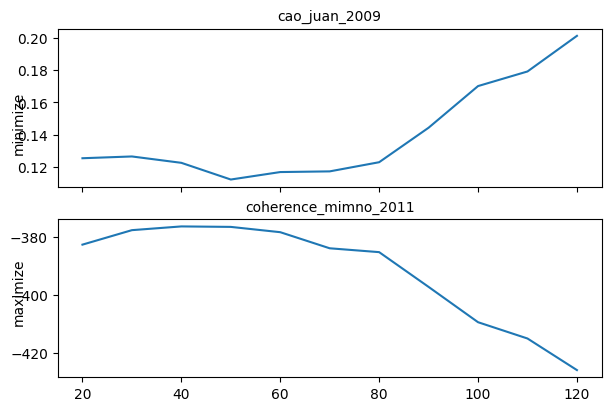

In [18]:
from tmtoolkit.topicmod.visualize import plot_eval_results

plot_eval_results(eval_results_by_topics);

The evaluation metrics seem to agree and show best fits for models with 30 to 70 topics. We would normally investigate a set of models in this range, but for simplicity, lets continue with a model with `n_topics=50` and `alpha=0.02`. We don't have to generate a model with these hyperparameters again, because it's already in the evaluation results (thanks to `return_models=True`). We extract the model from there in order to use it in the rest of the chapter.

In [19]:
best_tm = [m for k, m in eval_results_by_topics if k == 50][0]['model']
best_tm.n_topics, best_tm.alpha, best_tm.eta  # just to make sure

(50, 0.02, 0.1)

## Common statistics and tools for topic models

The [topicmod.model_stats](api.rst#module-tmtoolkit.topicmod.model_stats) module mostly contains functions that compute statistics from the document-topic and topic-word distribution of a topic model and also some helper functions for working with such distributions. We'll start with an important helper function, [generate_topic_labels_from_top_words](api.rst#tmtoolkit.topicmod.model_stats.generate_topic_labels_from_top_words).

### Generating labels for topics

In topic modeling, topics are numbered because they're *abstract* – they're simply a probability distribution across all words in the vocabulary. Still, it's useful to give them labels for better identification. The function [generate_topic_labels_from_top_words](api.rst#tmtoolkit.topicmod.model_stats.generate_topic_labels_from_top_words) is very useful for that, as it finds labels according to the most "relevant" words in each topic. We'll later see how we can identify the most relevant words per topic using a special [relevance statistic](#Topic-word-relevance). Note that you can adjust the weight of the relevance measure for the ranking by using the parameter `lambda_` which is in range $[0, 1]$.

The function requires at least the topic-word and document-topic distributions from the model, the document lengths and the vocabulary. It then finds the minimum number of relevant words that uniquely label each topic. You can also use a fixed number for that minimum number with the parameter `n_words`.

In [20]:
from tmtoolkit.bow.bow_stats import doc_lengths
from tmtoolkit.topicmod.model_stats import generate_topic_labels_from_top_words

vocab_bg = np.array(vocab_bg)   # we need this to be an array

doc_lengths_bg = doc_lengths(dtm_bg)
topic_labels = generate_topic_labels_from_top_words(
    best_tm.topic_word_,
    best_tm.doc_topic_,
    doc_lengths_bg,
    np.array(vocab_bg),
    lambda_=0.6
)

topic_labels[:10]   # showing only the first 5 topics here

array(['1_justice_charge', '2_north_post', '3_error_night',
       '4_sanction_action', '5_play_win', '6_say_issue', '7_shoot_police',
       '8_attack_group', '9_hope_family', '10_morning_day'], dtype='<U23')

As we can see, two words are necessary to label each topic uniquely. By default, each label is prefixed with a number. You can change that with the parameter `labels_format`.

Let's have a look at the top words for a specific topic. We can use [ldamodel_top_topic_words](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_words) for that from the module [topicmod.model_io](api.rst#module-tmtoolkit.topicmod.model_io), which we will have a closer look at [later](#Displaying-and-exporting-topic-modeling-results):

In [21]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_words

top_topic_word = ldamodel_top_topic_words(best_tm.topic_word_,
                                          vocab_bg,
                                          row_labels=topic_labels)
top_topic_word[top_topic_word.index == '7_shoot_police']

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
7_shoot_police,say (0.06056),police (0.05721),shoot (0.03714),man (0.0271),morning (0.0271),individual (0.02375),operation (0.01706),office (0.01706),press (0.01706),officer (0.01706)


### Marginal topic and word distributions

We'll now focus on the marginal topic and word distributions. Let's get the marginal topic distribution first by using [marginal_topic_distrib](api.rst#tmtoolkit.topicmod.model_stats.marginal_topic_distrib):

In [22]:
from tmtoolkit.topicmod.model_stats import marginal_topic_distrib

marg_topic = marginal_topic_distrib(best_tm.doc_topic_, doc_lengths_bg)
marg_topic

array([0.01326, 0.0101 , 0.01326, 0.01243, 0.01669, 0.03903, 0.01335,
       0.02143, 0.01505, 0.01166, 0.02023, 0.00638, 0.01657, 0.02442,
       0.01864, 0.01632, 0.0353 , 0.01557, 0.02558, 0.03151, 0.07525,
       0.03137, 0.03799, 0.01722, 0.03849, 0.01601, 0.01176, 0.02722,
       0.01473, 0.01371, 0.01834, 0.02296, 0.01685, 0.01186, 0.01732,
       0.01836, 0.00658, 0.00946, 0.02799, 0.01426, 0.02066, 0.01451,
       0.02185, 0.01681, 0.01152, 0.02701, 0.02122, 0.00784, 0.0203 ,
       0.01379])

The marginal topic distribution can be interpreted as the "importance" of each topic for the whole corpus. Let's get the sorted indices into `topic_labels` with `np.argsort` and get the top five topics:

In [23]:
# np.argsort gives ascending order, hence reverse via [::-1]
topic_labels[np.argsort(marg_topic)[::-1][:5]]

array(['21_year_time', '6_say_issue', '25_america_american',
       '23_white_trump', '17_country_love'], dtype='<U23')

Likewise, we can get the marginal word distribution with [marginal_word_distrib](api.rst#tmtoolkit.topicmod.model_stats.marginal_word_distrib) from the model's topic-word distribution and the marginal topic distribution. We'll use this to list the most probable words for the corpus. As expected, these are mostly quite common words:

In [24]:
from tmtoolkit.topicmod.model_stats import marginal_word_distrib

marg_word = marginal_word_distrib(best_tm.topic_word_, marg_topic)
vocab_bg[np.argsort(marg_word)[::-1][:10]]

array(['say', 'year', 'people', 'country', 'new', 'time', 'trump',
       'report', 'china', 'president'], dtype='<U14')

Two helper functions exist for this purpose: [most_probable_words](api.rst#tmtoolkit.topicmod.model_stats.most_probable_words) and [least_probable_words](api.rst#tmtoolkit.topicmod.model_stats.least_probable_words) sort the vocabulary according to the marginal probability:

In [25]:
from tmtoolkit.topicmod.model_stats import most_probable_words, least_probable_words

most_probable_words(vocab_bg, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths_bg,
                    n=10)

array(['say', 'year', 'people', 'country', 'new', 'time', 'trump',
       'report', 'china', 'president'], dtype='<U14')

In [26]:
least_probable_words(vocab_bg, best_tm.topic_word_,
                     best_tm.doc_topic_, doc_lengths_bg,
                     n=10)

array(['urge', 'reveal', 'conduct', 'indicate', 'seven', 'controversial',
       'analysis', 'argue', 'associate', 'guarantee'], dtype='<U14')

### Word distinctiveness and saliency

Word *distinctiveness* and *saliency* (see below) help to identify the most "informative" words in a corpus given its topic model. Both measures are introduced in [Chuang et al. 2012](https://dl.acm.org/citation.cfm?id=2254572).

Word distinctiveness is calculated for each word $w$ as

$\text{distinctiveness}(w) = \sum_T(P(T|w) \log \frac{P(T|w)}{P(T)})$.

where $P(T)$ is the marginal topic distribution and $P(T|w)$ is the probability of a topic given a word $w$.

We can calculate this measure using [word_distinctiveness](api.rst#tmtoolkit.topicmod.model_stats.word_distinctiveness). To use this measure directly to rank words, we can use [most_distinct_words](api.rst#tmtoolkit.topicmod.model_stats.most_distinct_words) and [least_distinct_words](api.rst#tmtoolkit.topicmod.model_stats.least_distinct_words):

In [27]:
from tmtoolkit.topicmod.model_stats import word_distinctiveness, \
    most_distinct_words, least_distinct_words

word_distinct = word_distinctiveness(best_tm.topic_word_, marg_topic)
word_distinct[:10]   # first 10 words in vocab

array([0.78729, 1.72026, 1.02646, 1.08976, 1.46623, 0.75563, 0.9307 ,
       0.79992, 1.37157, 1.40561])

In [28]:
most_distinct_words(vocab_bg, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths_bg,
                    n=10)

array(['north', 'bank', 'flight', 'china', 'space', 'judge', 'justice',
       'display', 'relation', 'morning'], dtype='<U14')

In [29]:
least_distinct_words(vocab_bg, best_tm.topic_word_,
                     best_tm.doc_topic_, doc_lengths_bg,
                     n=10)

array(['rely', 'series', 'ready', 'discussion', 'saturday', 'adopt',
       'ago', 'well', 'sure', 'away'], dtype='<U14')

Word *saliency* weights each words' distinctiveness by it's marginal probability $P(w)$:

$\text{saliency}(w) = P(w) \cdot \text{distinctiveness}(w)$.

The respective functions in tmtoolkit are [word_saliency](api.rst#tmtoolkit.topicmod.model_stats.word_saliency), [most_salient_words](api.rst#tmtoolkit.topicmod.model_stats.most_salient_words) and [least_salient_words](api.rst#tmtoolkit.topicmod.model_stats.least_salient_words):

In [30]:
from tmtoolkit.topicmod.model_stats import word_saliency, \
    most_salient_words, least_salient_words

word_sal = word_saliency(best_tm.topic_word_, best_tm.doc_topic_, doc_lengths_bg)
word_sal[:10]   # first 10 words in vocab

array([0.00079, 0.00182, 0.0008 , 0.00085, 0.00081, 0.00061, 0.00065,
       0.00048, 0.00095, 0.00098])

In [31]:
most_salient_words(vocab_bg, best_tm.topic_word_,
                   best_tm.doc_topic_, doc_lengths_bg,
                   n=10)

array(['say', 'china', 'trump', 'year', 'country', 'people', 'report',
       'president', 'new', 'company'], dtype='<U14')

In [32]:
least_salient_words(vocab_bg, best_tm.topic_word_,
                    best_tm.doc_topic_, doc_lengths_bg,
                    n=10)

array(['series', 'rely', 'discussion', 'adopt', 'ready', 'avoid', 'sure',
       'saturday', 'theme', 'reportedly'], dtype='<U14')

### Topic-word relevance

The topic-word relevance measure as introduced by [Sievert and Shirley 2014](https://www.aclweb.org/anthology/W14-3110/) helps to identify the most relevant words within a topic by also accounting for the marginal probability of each word across the corpus. This is done by integrating a *lift* value, which is the "ratio of a term's probability within a topic to its marginal probability across the corpus." (ibid.)

Thus for each word $w$, given a topic-word distribution $\phi$, a topic $t$ and a weight parameter $\lambda$, it is calculated as:

$\text{relevance}_{\phi, \lambda}(w, t) = \lambda \log \phi_{t,w} + (1-\lambda) \log \frac{\phi_{t,w}}{p(w)}$.

The first term $\log \phi_{t,w}$ is the log of the topic-word distribution, the second term $\log \frac{\phi_{t,w}}{p(w)}$ is the *log lift* and $\lambda$ can be used to control the weight between both terms. The lower $\lambda$, the more weight is put on the lift term, i.e. the more different are the results from the original topic-word distribution.

This measure is implemented in [topic_word_relevance](api.rst#tmtoolkit.topicmod.model_stats.topic_word_relevance). It returns a matrix of the same shape as the topic-word distribution, i.e. each row represents a topic with a (log-transformed) distribution across all words in the vocabulary. Please note that the lambda parameter ends with an underscore: `lambda_`.

In [33]:
from tmtoolkit.topicmod.model_stats import topic_word_relevance

topic_word_rel = topic_word_relevance(best_tm.topic_word_, best_tm.doc_topic_,
                                      doc_lengths_bg, lambda_=0.6)
topic_word_rel

array([[-5.23465, -5.25598, -5.13452, ..., -6.14689, -5.22336, -5.40088],
       [-5.04211, -5.06343, -4.94197, ..., -5.95435, -5.03081, -5.20834],
       [-5.23465, -5.25598, -5.13452, ..., -6.14689, -5.22336, -5.40088],
       ...,
       [-4.87349, -1.18125, -4.77336, ..., -3.38784, -4.8622 , -5.03972],
       [-5.56688, -5.58821, -5.46674, ..., -1.96826, -5.55559, -5.73311],
       [-5.26451, -5.28584, -5.16438, ..., -6.17675, -5.25322, -5.43074]])

To confirm that it's 50 topics across all words in the vocabulary:

In [34]:
topic_word_rel.shape

(50, 789)

Two functions can be used to get the most or least relevant words for a topic: [most_relevant_words_for_topic](api.rst#tmtoolkit.topicmod.model_stats.most_relevant_words_for_topic) and [least_relevant_words_for_topic](api.rst#tmtoolkit.topicmod.model_stats.least_relevant_words_for_topic). You can select the topic with the `topic` parameter which is a **zero-based topic index**.

We'll do it for topic with index 9, which is:

In [35]:
topic_labels[9]

'10_morning_day'

In [36]:
from tmtoolkit.topicmod.model_stats import most_relevant_words_for_topic, \
    least_relevant_words_for_topic

most_relevant_words_for_topic(vocab_bg, topic_word_rel, topic=9, n=10)

array(['morning', 'day', 'partner', 'start', 'walk', 'likely', 'chance',
       'help', 'foot', 'boost'], dtype='<U14')

In [37]:
least_relevant_words_for_topic(vocab_bg, topic_word_rel, topic=9, n=10)

array(['say', 'year', 'people', 'country', 'new', 'time', 'trump',
       'report', 'china', 'president'], dtype='<U14')

### Topic coherence

We already used the *coherence* metric ([Mimno et al. 2011](https://dl.acm.org/citation.cfm?id=2145462)) for topic model evaluation. However, this metric cannot only be used to assess the overall quality of a topic model, but also to evaluate the individual topics' coherence.

In [38]:
from tmtoolkit.topicmod.evaluate import metric_coherence_mimno_2011

# use top 20 words per topic for metric
coh = metric_coherence_mimno_2011(best_tm.topic_word_, dtm_bg, top_n=10, include_prob=True)
coh

array([-381.19764, -405.21699, -385.14085, -382.9605 , -377.73554,
       -385.5327 , -381.7741 , -366.53703, -384.22751, -387.94505,
       -374.08057, -377.80028, -369.7097 , -368.60895, -393.62278,
       -402.06989, -356.06615, -373.96911, -339.94301, -350.93052,
       -345.55067, -349.02383, -350.14311, -365.86664, -373.2819 ,
       -368.1276 , -399.61229, -371.58258, -381.01624, -407.47346,
       -376.48966, -390.12855, -405.42291, -387.12314, -361.73032,
       -372.84445, -393.99511, -380.1421 , -370.90795, -367.79897,
       -381.71496, -373.34488, -358.05694, -366.27945, -367.27849,
       -389.31761, -368.70005, -406.87429, -381.88397, -370.53712])

This generates a coherence value for each topic. Let's show the distribution of these values:

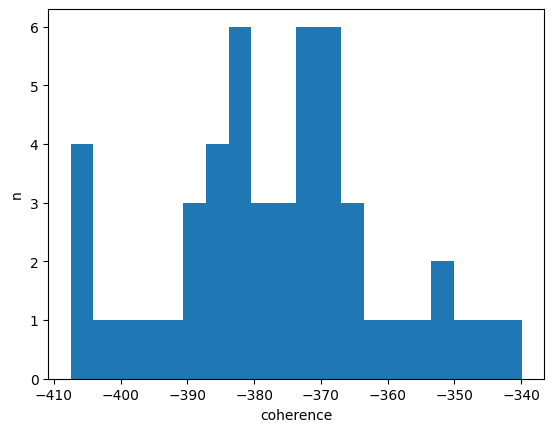

In [39]:
import matplotlib.pyplot as plt

plt.hist(coh, bins=20)
plt.xlabel('coherence')
plt.ylabel('n')
plt.show();

And print the best and worst topics according to this metric:

In [40]:
import numpy as np

top10_t_indices = np.argsort(coh)[::-1][:10]
bottom10_t_indices = np.argsort(coh)[:10]

topic_labels[top10_t_indices]

array(['19_al_syrian', '21_year_time', '22_china_chinese',
       '23_white_trump', '20_report_agency', '17_country_love',
       '43_russian_moscow', '35_intelligence_russia', '24_parent_child',
       '44_bill_health'], dtype='<U23')

In [41]:
topic_labels[bottom10_t_indices]

array(['30_step_authority', '48_bank_asset', '33_force_group',
       '2_north_post', '16_2011_people', '27_space_european',
       '37_relation_contact', '15_club_institute', '32_fight_provide',
       '46_say_mr'], dtype='<U23')

Note that this metric also doesn't spare oneself careful manual evaluation, because it can also be off for some topics. For example, topic `21_year_time` is certainly not a coherent topic as it mostly ranks very common but less meaningful words high:

In [42]:
top_topic_word[top_topic_word.index == '21_year_time']

,rank_1,rank_2,rank_3,rank_4,rank_5,rank_6,rank_7,rank_8,rank_9,rank_10
topic,,,,,,,,,,
21_year_time,say (0.08178),year (0.06211),time (0.04395),people (0.03639),come (0.02428),want (0.02201),tell (0.02126),work (0.01974),go (0.01899),long (0.01823)


More coherence metrics can be used with the function [metric_coherence_gensim](api.rst#tmtoolkit.topicmod.evaluate.metric_coherence_gensim). This requires that [gensim](https://radimrehurek.com/gensim/) is installed. Furthemore, most metrics require that a parameter `texts` is passed which is the tokenized text that was used to create the document-term matrix.

### Filtering topics

With the function [filter_topics](api.rst#tmtoolkit.topicmod.model_stats.filter_topics), you can filter the topics according to their topic-word distribution and the following search criteria:

- `search_pattern`: one or more search patterns according to the [common parameters for pattern matching](preprocessing.ipynb#Common-parameters-for-pattern-matching-functions)
- `top_n`: pattern match(es) must occur in the first `top_n` most probable words in the topic
- `thresh`: matched words' probability must be above this threshold

You must specify at least one of `top_n` and `thresh`, but you can also specify both. The function returns an array of topic indices (which start with zero!).

Let's find all topics that have the glob pattern (`match_type='glob'`) "russ*" (to match both "russia" and "russian") in the top 5 most probable words:

In [43]:
from tmtoolkit.topicmod.model_stats import filter_topics

found_topics = filter_topics('russ*', vocab_bg,
                             best_tm.topic_word_, match_type='glob',
                             top_n=5)
found_topics

array([ 3, 34, 42])

We can use these indices with our `topic_labels`:

In [44]:
topic_labels[found_topics]

array(['4_sanction_action', '35_intelligence_russia', '43_russian_moscow'],
      dtype='<U23')

Next, we want to select all topics where *any* of the words matched by the glob patterns `"chin*"` *or* `"business"` achieve at least a probability of 0.01 (`thresh=0.01`):

In [45]:
found_topics = filter_topics(['chin*', 'business'], vocab_bg,
                             best_tm.topic_word_, thresh=0.01, match_type='glob')
topic_labels[found_topics]

array(['6_say_issue', '9_hope_family', '22_china_chinese',
       '27_space_european'], dtype='<U23')

When we specify `cond='all'`, *all* patterns must have at least one match (here in the top 10 list of words per topic):

In [46]:
found_topics = filter_topics(['chin*', 'business'], vocab_bg,
                             best_tm.topic_word_, top_n=10, match_type='glob',
                             cond='all')
topic_labels[found_topics]   # no result

array([], dtype='<U23')

You could also pass a topic-word relevance matrix instead of a topic-word probability distribution.

In [47]:
found_topics = filter_topics('russ*', vocab_bg,
                             topic_word_rel, match_type='glob',
                             top_n=5)
topic_labels[found_topics]

array(['4_sanction_action', '35_intelligence_russia', '43_russian_moscow'],
      dtype='<U23')

### Excluding topics

It is often the case that some topics of a topic model rank a lot of uninformative (e.g. very common) words the highest. This results in some uninformative topics, which you may want to exclude from further analysis. Note that if a large fraction of topics seems uninformative, it points to a problem with your topic model and/or your preprocessing steps. You should [evaluate](#Evaluation-of-topic-models) your candidate models carefully with the mentioned metrics and/or adjust your text preprocessing pipeline.

The function [exclude_topics](api.rst#tmtoolkit.topicmod.model_stats.exclude_topics) allows to remove a specified set of topics from the document-topic and topic-word distributions. You need to pass the **zero-based** indices of the topics that you want to remove, and both distributions.

For example, suppose the following topics were identified as uninformative:

In [48]:
uninform_topics = [5, 20, 32, 40, 45]
topic_labels[uninform_topics]

array(['6_say_issue', '21_year_time', '33_force_group', '41_line_look',
       '46_say_mr'], dtype='<U23')

We can now pass these indices to [exclude_topics](api.rst#tmtoolkit.topicmod.model_stats.exclude_topics) along with the topic model distributions. We'll get back new, filtered, distributions.

In [49]:
from tmtoolkit.topicmod.model_stats import exclude_topics

new_doc_topic, new_topic_word, new_topic_mapping = \
    exclude_topics(uninform_topics, best_tm.doc_topic_,
                best_tm.topic_word_, return_new_topic_mapping=True)
new_doc_topic.shape, new_topic_word.shape

((100, 45), (45, 789))

We can see in the new distributions' shapes that we now have 47 instead of 50 topics, because we removed three of them. We shouldn't forget to also update the topic labels and remove the unwanted topics:

In [50]:
new_topic_labels = np.delete(topic_labels, uninform_topics)
new_topic_labels

array(['1_justice_charge', '2_north_post', '3_error_night',
       '4_sanction_action', '5_play_win', '7_shoot_police',
       '8_attack_group', '9_hope_family', '10_morning_day',
       '11_german_germany', '12_council_circumstance',
       '13_southern_reject', '14_investment_company', '15_club_institute',
       '16_2011_people', '17_country_love', '18_officer_police',
       '19_al_syrian', '20_report_agency', '22_china_chinese',
       '23_white_trump', '24_parent_child', '25_america_american',
       '26_world_meeting', '27_space_european', '28_company_reform',
       '29_fire_death', '30_step_authority', '31_party_leader',
       '32_fight_provide', '34_percent_french', '35_intelligence_russia',
       '36_trump_president', '37_relation_contact', '38_flight_display',
       '39_vote_feel', '40_election_northern', '42_man_accord',
       '43_russian_moscow', '44_bill_health', '45_judge_victim',
       '47_minister_president', '48_bank_asset', '49_mr_damage',
       '50_note_sell'

## Displaying and exporting topic modeling results

The [topicmod.model_io](api.rst#module-tmtoolkit.topicmod.model_io) module provides several functions for displaying and exporting topic modeling results, i.e. results derived from the document-topic and topic-word distribution of a given topic model.

We already used [ldamodel_top_topic_words](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_words) briefly, which generates a dataframe with the top words from a topic-word distribution. You can also use the topic-word relevance matrix instead. With `top_n` we can control the number of top words:

In [51]:
# using relevance matrix here and showing only the first 3 topics
ldamodel_top_topic_words(topic_word_rel, vocab_bg, top_n=5)[:3]

,rank_1,rank_2,rank_3,rank_4,rank_5
topic,,,,,
topic_1,justice (-0.2563),charge (-0.6977),department (-0.7619),need (-0.9191),future (-1.037)
topic_2,north (0.3636),post (-0.7892),leader (-0.8919),body (-0.916),tie (-1.246)
topic_3,error (-0.7178),night (-0.8708),stage (-0.8802),hand (-1.057),case (-1.08)


If you're interested in the top *topics for each word/token*, you can use [ldamodel_top_word_topics](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_word_topics). Here, we generate the top five topics for each token in the vocabulary, but only display the output for four specific words. Instead of the generic `"topic_..."` topic names, we additionally pass our previously generated topic labels `topic_labels`:

In [52]:
from tmtoolkit.topicmod.model_io import ldamodel_top_word_topics

top_word_topics = ldamodel_top_word_topics(topic_word_rel, vocab_bg,
                                           top_n=5, topic_labels=topic_labels)
top_word_topics[top_word_topics.index.isin(['china', 'chinese', 'russia', 'russian'])]

,rank_1,rank_2,rank_3,rank_4,rank_5
token,,,,,
china,22_china_chinese (0.2341),14_investment_company (-3.969),12_council_circumstance (-5.398),37_relation_contact (-5.414),48_bank_asset (-5.521)
chinese,22_china_chinese (-0.617),27_space_european (-1.682),5_play_win (-2.617),12_council_circumstance (-4.999),37_relation_contact (-5.015)
russia,43_russian_moscow (-0.6884),35_intelligence_russia (-0.7184),4_sanction_action (-1.154),5_play_win (-2.73),9_hope_family (-3.295)
russian,43_russian_moscow (-0.08055),35_intelligence_russia (-1.267),19_al_syrian (-2.768),29_fire_death (-3.359),5_play_win (-3.46)


Note that the values in parantheses are the corresponding values from the matrix for that word in that topic. They're negative because of the log transformation that is applied in the topic-word relevance measure.

Similar functions can be used for the document-topic distribution: [ldamodel_top_doc_topics](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_doc_topics) gives the top topics per document and [ldamodel_top_topic_docs](api.rst#tmtoolkit.topicmod.model_io.ldamodel_top_topic_docs) gives the top documents per topic. Here, `top_n` controls the number of top-ranked topics or documents to return, respectively. This time, we use the filtered document-topic distribution `new_doc_topics`:

In [53]:
from tmtoolkit.topicmod.model_io import ldamodel_top_doc_topics

ldamodel_top_doc_topics(new_doc_topic, doc_labels_bg, top_n=3,
                        topic_labels=new_topic_labels)[:5]

,rank_1,rank_2,rank_3
document,,,
NewsArticles-1032,31_party_leader (0.9579),20_report_agency (0.01743),39_vote_feel (0.01743)
NewsArticles-1036,8_attack_group (0.2678),20_report_agency (0.2302),11_german_germany (0.1927)
NewsArticles-104,49_mr_damage (0.5089),9_hope_family (0.2557),47_minister_president (0.1291)
NewsArticles-1043,5_play_win (0.5088),19_al_syrian (0.2622),7_shoot_police (0.2006)
NewsArticles-1048,18_officer_police (0.7435),20_report_agency (0.1931),4_sanction_action (0.04303)


And now for the top documents per topic:

In [54]:
from tmtoolkit.topicmod.model_io import ldamodel_top_topic_docs

ldamodel_top_topic_docs(new_doc_topic, doc_labels_bg, top_n=3,
                        topic_labels=new_topic_labels)[:5]

,rank_1,rank_2,rank_3
topic,,,
1_justice_charge,NewsArticles-1341 (0.8213),NewsArticles-2617 (0.4118),NewsArticles-248 (0.1688)
2_north_post,NewsArticles-2101 (0.6114),NewsArticles-3573 (0.5619),NewsArticles-3023 (0.4452)
3_error_night,NewsArticles-1539 (0.8661),NewsArticles-1295 (0.7066),NewsArticles-1090 (0.6058)
4_sanction_action,NewsArticles-709 (0.5343),NewsArticles-3246 (0.4311),NewsArticles-3263 (0.2096)
5_play_win,NewsArticles-693 (0.9697),NewsArticles-1126 (0.604),NewsArticles-3263 (0.5384)


There are also two functions that generate datatables for the full topic-word and document-topic distributions: [ldamodel_full_topic_words](api.rst#tmtoolkit.topicmod.model_io.ldamodel_full_topic_words) and [ldamodel_full_doc_topics](api.rst#tmtoolkit.topicmod.model_io.ldamodel_full_doc_topics). The output of both functions is naturally quite big, as long as you're not working with a "toy dataset".

In [55]:
from tmtoolkit.topicmod.model_io import ldamodel_full_topic_words

df_topic_word = ldamodel_full_topic_words(new_topic_word,
                                          vocab_bg,
                                          row_labels=new_topic_labels)
# displaying only the first 5 topics with 10 tokens
# from sorted vocabulary list (tokens 120 to 129)
df_topic_word.iloc[:5, 120:130]

,central,centre,century,certain,chairman,challenge,chance,change,charge,check
0,0.000337,0.000337,0.000337,0.000337,0.000337,0.003705,0.003705,0.000337,0.034018,0.000337
1,0.000408,0.000408,0.000408,0.000408,0.000408,0.000408,0.000408,0.000408,0.000408,0.008575
2,0.000337,0.000337,0.000337,0.000337,0.000337,0.000337,0.000337,0.000337,0.003705,0.000337
3,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353
4,0.000282,0.000282,0.003099,0.000282,0.000282,0.000282,0.000282,0.003099,0.000282,0.000282


In [56]:
from tmtoolkit.topicmod.model_io import ldamodel_full_doc_topics

df_doc_topic = ldamodel_full_doc_topics(new_doc_topic,
                                        doc_labels_bg,
                                        topic_labels=new_topic_labels)
# displaying only the first 3 documents with the first
# 5 topics
df_doc_topic.iloc[:3, :5]

,_doc,1_justice_charge,2_north_post,3_error_night,4_sanction_action
0,NewsArticles-1032,0.000173,0.000173,0.000173,0.000173
1,NewsArticles-1036,0.000094,0.000094,0.000094,0.000094
2,NewsArticles-104,0.002532,0.002532,0.002532,0.002532


For quick inspection of topics there's also a pair of print functions. We already used [print_ldamodel_topic_words](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_topic_words), but we haven't tried [print_ldamodel_doc_topics](api.rst#tmtoolkit.topicmod.model_io.print_ldamodel_doc_topics) yet. This prints the `top_n` most probable topics for each document:

In [57]:
from tmtoolkit.topicmod.model_io import print_ldamodel_doc_topics

# subsetting new_doc_topic and doc_labels to get only the first
# five documents
print_ldamodel_doc_topics(new_doc_topic[:5, :], doc_labels_bg[:5],
                          val_labels=new_topic_labels)

NewsArticles-1032
> #1. 31_party_leader (0.957895)
> #2. 20_report_agency (0.017429)
> #3. 39_vote_feel (0.017429)
NewsArticles-1036
> #1. 8_attack_group (0.267825)
> #2. 20_report_agency (0.230249)
> #3. 11_german_germany (0.192673)
NewsArticles-104
> #1. 49_mr_damage (0.508861)
> #2. 9_hope_family (0.255696)
> #3. 47_minister_president (0.129114)
NewsArticles-1043
> #1. 5_play_win (0.508783)
> #2. 19_al_syrian (0.262250)
> #3. 7_shoot_police (0.200616)
NewsArticles-1048
> #1. 18_officer_police (0.743531)
> #2. 20_report_agency (0.193138)
> #3. 4_sanction_action (0.043031)


You can also export the results of a topic model to an Excel file using [save_ldamodel_summary_to_excel](api.rst#tmtoolkit.topicmod.model_io.save_ldamodel_summary_to_excel). The resulting Excel file will contain the following sheets:

- `top_doc_topics_vals`: document-topic distribution with probabilities of top topics per document
- `top_doc_topics_labels`: document-topic distribution with labels of top topics per document
- `top_doc_topics_labelled_vals`: document-topic distribution combining probabilities and labels of top topics per
  document (e.g. `"topic_12 (0.21)"`)
- `top_topic_word_vals`: topic-word distribution with probabilities of top words per topic
- `top_topic_word_labels`: topic-word distribution with top words per (e.g. `"politics"`) topic
- `top_topic_words_labelled_vals`: topic-word distribution combining probabilities and top words per topic
  (e.g. `"politics (0.08)"`)
- optional if `dtm` is given – `marginal_topic_distrib`: marginal topic distribution

Additionally to saving the output to the specified Excel file, the function will also return a dict with the sheets and their data.

In [58]:
from tmtoolkit.topicmod.model_io import save_ldamodel_summary_to_excel

sheets = save_ldamodel_summary_to_excel('data/news_articles_100.xlsx',
                                        new_topic_word, new_doc_topic,
                                        doc_labels_bg, vocab_bg,
                                        dtm = dtm_bg,
                                        topic_labels = new_topic_labels)

To quickly store a topic model to disk for sharing or loading again at a later point in time, there are [save_ldamodel_to_pickle](api.rst#tmtoolkit.topicmod.model_io.save_ldamodel_to_pickle) and [load_ldamodel_from_pickle](api.rst#tmtoolkit.topicmod.model_io.load_ldamodel_from_pickle). The function for saving takes a path to a pickle file to create (or update), a topic model object (such as an LDA instance as `best_tm`, but you could also pass a tuple like `(new_doc_topic, new_topic_word)`), the corresponding vocabulary and document labels, and optionally the DTM that was used to create the topic model. The function for loading the data will return the saved data as a dict. We will only show the dict's keys here, as the data itself is too large to be printed: 

In [59]:
from tmtoolkit.topicmod.model_io import save_ldamodel_to_pickle, \
    load_ldamodel_from_pickle

save_ldamodel_to_pickle('data/news_articles_100.pickle',
                        best_tm, vocab_bg, doc_labels_bg,
                        dtm = dtm_bg)

loaded = load_ldamodel_from_pickle('data/news_articles_100.pickle')
loaded.keys()

dict_keys(['model', 'vocab', 'doc_labels', 'dtm'])

## Visualizing topic models

The [topicmod.visualize](api.rst#visualize-topic-models-and-topic-model-evaluation-results) module contains several functions to visualize topic models and evaluation results. We've already used [plot_eval_results](api.rst#tmtoolkit.topicmod.visualize.plot_eval_results) during [topic model evaluation](#Evaluation-of-topic-models) so we'll now focus on visualizing topic models.

### Heatmaps

Let's start with heatmap visualizations of document-topic or topic-word distributions from our topic model. This can be done with [plot_doc_topic_heatmap](api.rst#tmtoolkit.topicmod.visualize.plot_doc_topic_heatmap) and [plot_topic_word_heatmap](api.rst#tmtoolkit.topicmod.visualize.plot_topic_word_heatmap) respectively. Both functions draw on a [matplotlib](https://matplotlib.org/) figure and *Axes* object, which you must create before using these functions.

Heatmap visualizations essentially shade cells in a 2D matrix (like the document-topic or topic-word distributions) according to their value, i.e. the respective probability for a topic in a given document or a word in a given topic. Since these matrices are usually quite large, i.e. with hundreds of rows and/or columns, it doesn't make sense to plot a heatmap of the whole matrix, but rather a certain subset of interest. When we want to visualize a document-topic distribution, we can optionally select a subset of the documents with the `which_documents` parameter and a subset of the topics with the `which_topics` parameter. Let's draw a heatmap of a subset of documents across all topics at first:

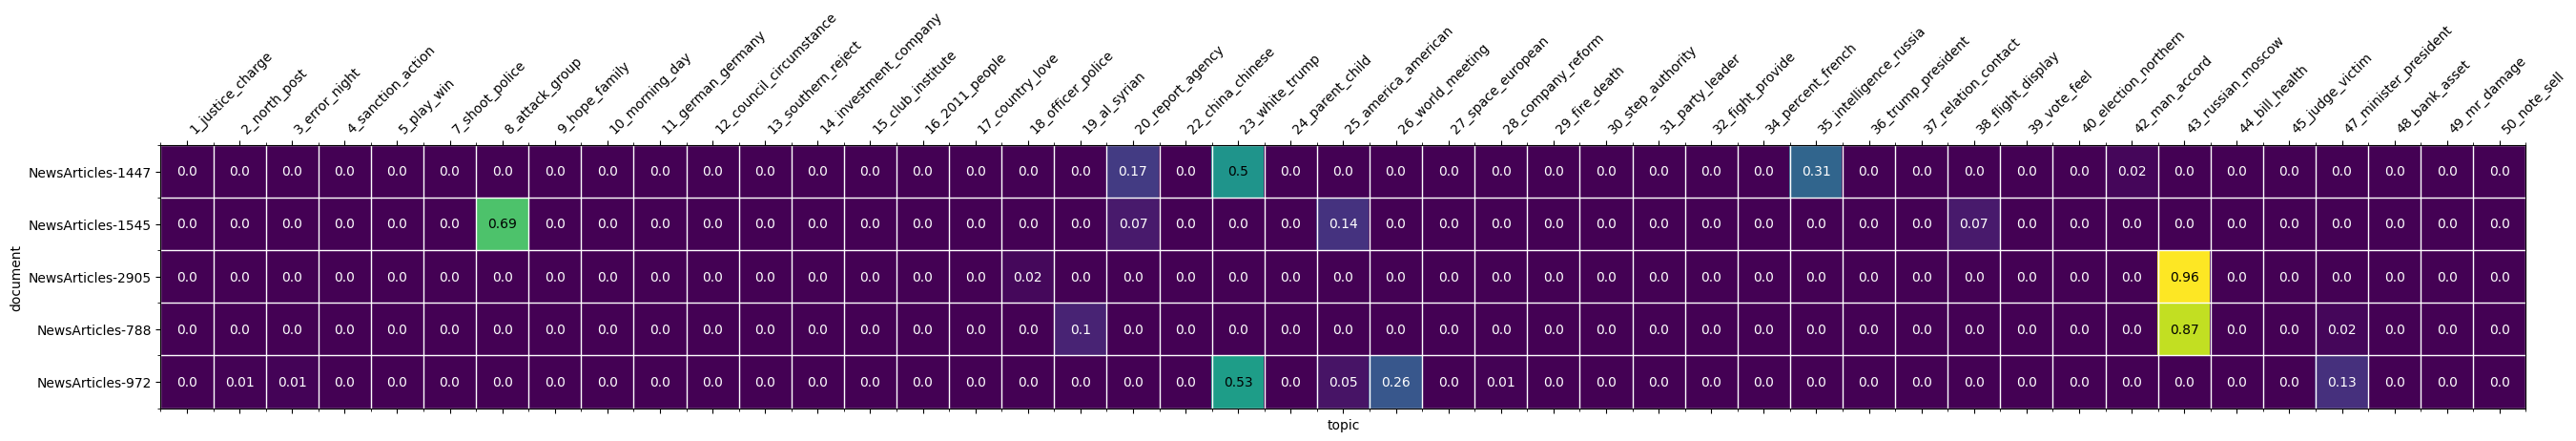

In [60]:
import matplotlib.pyplot as plt
from tmtoolkit.topicmod.visualize import plot_doc_topic_heatmap

# create a figure of certain size and
# Axes object to draw on
fig, ax = plt.subplots(figsize=(32, 8))

# randomly selecting a subset of documents
which_docs = random.sample(doc_labels_bg, 5)

plot_doc_topic_heatmap(fig, ax, new_doc_topic, doc_labels_bg,
                       topic_labels=new_topic_labels,
                       which_documents=which_docs);

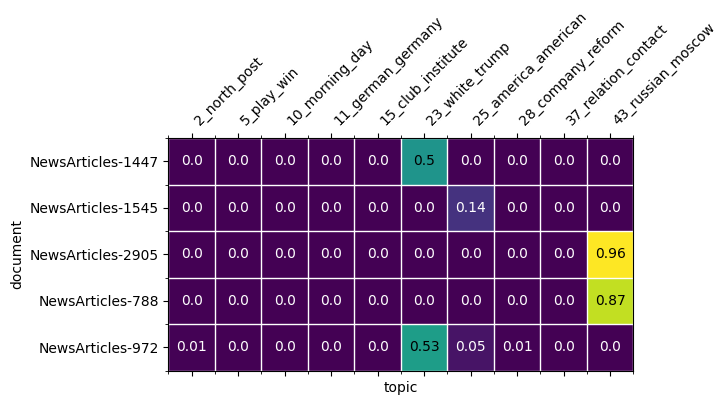

In [61]:
fig, ax = plt.subplots(figsize=(6, 8))

# randomly selecting a subset of topics
which_topics = random.sample(list(new_topic_labels), 10)

plot_doc_topic_heatmap(fig, ax, new_doc_topic, doc_labels_bg,
                       topic_labels=new_topic_labels,
                       which_documents=which_docs,
                       which_topics=which_topics);

Similarily, we can work with [plot_topic_word_heatmap](api.rst#tmtoolkit.topicmod.visualize.plot_topic_word_heatmap) to visualize a topic-word distribution. We can also select a subset of topics and words from the vocabulary:

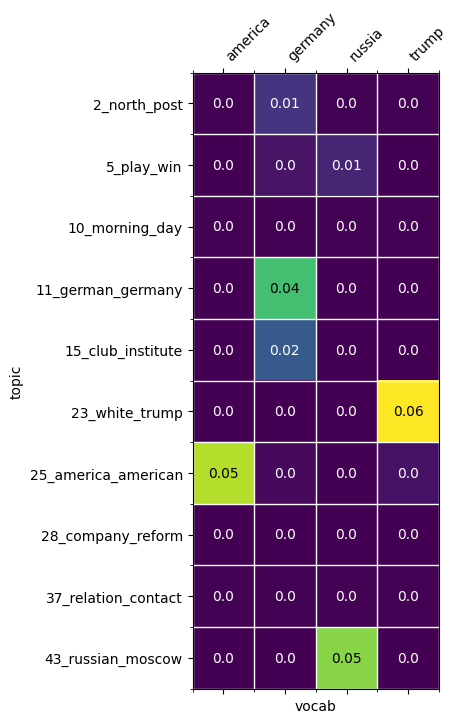

In [62]:
from tmtoolkit.topicmod.visualize import plot_topic_word_heatmap

fig, ax = plt.subplots(figsize=(12, 8))

which_words = ['trump', 'america', 'russia', 'germany']

plot_topic_word_heatmap(fig, ax, new_topic_word, vocab_bg,
                        topic_labels=new_topic_labels,
                        which_topics=which_topics,
                        which_words=which_words);

Note that there's also a generic heatmap plotting function [plot_heatmap](api.rst#plot-heatmaps-for-topic-models) for any kind of 2D matrices. 

### Word clouds

Thanks to the [wordlcloud package](https://pypi.org/project/wordcloud/), topic-word and document-topic distributions can also be visualized as "word clouds" with tmtoolkit. The function [generate_wordclouds_for_topic_words](api.rst#tmtoolkit.topicmod.visualize.generate_wordclouds_for_topic_words) generates a word cloud for each topic by scaling a topic's word by its probability (weight). You can choose to display only the top `top_n` words per topic. The result of this function will be a dictionary mapping topic labels to the respective word cloud image.

In [63]:
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_topic_words

# some options for wordcloud output
img_w = 400   # image width
img_h = 300   # image height

topic_clouds = generate_wordclouds_for_topic_words(
    new_topic_word, vocab_bg,
    top_n=20, topic_labels=new_topic_labels,
    width=img_w, height=img_h
)

# show all generated word clouds
topic_clouds.keys()

dict_keys(['1_justice_charge', '2_north_post', '3_error_night', '4_sanction_action', '5_play_win', '7_shoot_police', '8_attack_group', '9_hope_family', '10_morning_day', '11_german_germany', '12_council_circumstance', '13_southern_reject', '14_investment_company', '15_club_institute', '16_2011_people', '17_country_love', '18_officer_police', '19_al_syrian', '20_report_agency', '22_china_chinese', '23_white_trump', '24_parent_child', '25_america_american', '26_world_meeting', '27_space_european', '28_company_reform', '29_fire_death', '30_step_authority', '31_party_leader', '32_fight_provide', '34_percent_french', '35_intelligence_russia', '36_trump_president', '37_relation_contact', '38_flight_display', '39_vote_feel', '40_election_northern', '42_man_accord', '43_russian_moscow', '44_bill_health', '45_judge_victim', '47_minister_president', '48_bank_asset', '49_mr_damage', '50_note_sell'])

Let's select specific topics and display their word cloud:

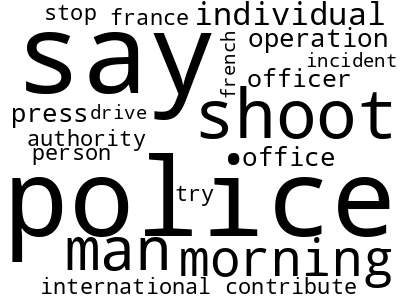

In [64]:
topic_clouds['7_shoot_police']

The same can be done for the document-topic distribution using [generate_wordclouds_for_document_topics](api.rst#tmtoolkit.topicmod.visualize.generate_wordclouds_for_document_topics). Here, a word cloud for each document will be generated that contains the `top_n` most probable topics for this document:

In [65]:
from tmtoolkit.topicmod.visualize import generate_wordclouds_for_document_topics

doc_clouds = generate_wordclouds_for_document_topics(
    new_doc_topic, doc_labels_bg, topic_labels=new_topic_labels,
    top_n=5, width=img_w, height=img_h)

# show only the first 5 documents for
# which word clouds were generated
list(doc_clouds.keys())[:5]

['NewsArticles-1032',
 'NewsArticles-1036',
 'NewsArticles-104',
 'NewsArticles-1043',
 'NewsArticles-1048']

To display a specific document's topic word cloud:

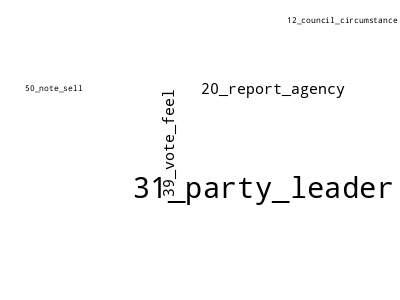

In [66]:
doc_clouds['NewsArticles-1032']

We can write the generated images as PNG files to a folder on disk. Here, we store all word clouds in `topic_clouds` to `'data/tm_wordclouds/'`:

In [67]:
from tmtoolkit.topicmod.visualize import write_wordclouds_to_folder

write_wordclouds_to_folder(topic_clouds, 'data/tm_wordclouds/')

### Interactive visualization with pyLDAVis

The [pyLDAVis package](https://pyldavis.readthedocs.io/) offers a great interactive tool to explore a topic model. The tmtoolkit function [parameters_for_ldavis](api.rst#tmtoolkit.topicmod.visualize.generate_wordclouds_for_document_topics) allows to prepare your topic model data for this package so that you can easily pass it on to pyLDAVis.

In [68]:
from tmtoolkit.topicmod.visualize import parameters_for_ldavis

ldavis_params = parameters_for_ldavis(new_topic_word,
                                      new_doc_topic,
                                      dtm_bg,
                                      vocab_bg)

If you have installed the package, you can now start the LDAVis explorer with the following lines of code in a Jupyter notebook:

    import pyLDAvis
    pyLDAVis.prepare(**ldavis_params)